<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Working/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [2]:
# #refesh python script
# get_ipython().kernel.do_shutdown(restart=True)

# #Check GPUs
# !nvidia-smi

#load cudf to use GPUs for analysis
#%load_ext cudf.pandas

# import pandas
import pandas as pd
import datetime
import pickle
import numpy as np
from tqdm.notebook import tqdm
import requests
from datetime import datetime, timedelta
import time
import os

# from google.colab import drive
# drive.mount('/content/drive')

#!pip install tqdm==4.66.1



# Ensure the last 6 months of EODHD Data is available

In [3]:
# Ensure the last 6 months of EODHD Data is available
"""
Returns:
nasdaq_df: A pandas DataFrame with the columns
  date
  ticker
  open
  high
  low
  close
  adjusted_close
  volume
"""
#API_KEY = 'demo'  # Replace with your API key if not using demo
API_KEY = '68433aff09ea73.10710364'
EXCHANGE = 'NASDAQ'
DAYS_BACK = 180  # Approx. 6 months
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv'
MAX_CALLS_PER_RUN = 200  # Use 1–5 for the free tier
SECONDS_BETWEEN_CALLS = 0  # Add delay to be respectful

# Generate past 6 months of weekdays
today = datetime.utcnow().date()
dates = [today - timedelta(days=i) for i in range(DAYS_BACK)]
dates = sorted([d for d in dates if d.weekday() < 5])  # Keep only weekdays

# Load already-downloaded dates if file exists
downloaded_dates = set()
if os.path.exists(SAVE_PATH):
    df_existing = pd.read_csv(SAVE_PATH)
    downloaded_dates = set(pd.to_datetime(df_existing['date']).dt.date)
# Filter to only dates we haven’t downloaded
pending_dates = [d for d in dates if d not in downloaded_dates]

# Prepare data holder
all_data = []

for i, date in enumerate(pending_dates[:MAX_CALLS_PER_RUN]):
    date_str = date.strftime('%Y-%m-%d')
    url = f'https://eodhd.com/api/eod-bulk-last-day/{EXCHANGE}?api_token={API_KEY}&fmt=json&date={date_str}'
    print(f"[{i+1}] Fetching {date_str}...")

    try:
        response = requests.get(url)
        response.raise_for_status()
        day_data = response.json()

        for entry in day_data:
            all_data.append({
                'date': entry.get('date'),
                'ticker': entry.get('code'),
                'open': entry.get('open'),
                'high': entry.get('high'),
                'low': entry.get('low'),
                'close': entry.get('close'),
                'adjusted_close': entry.get('adjusted_close'),
                'volume': entry.get('volume'),
            })

        # Respect the delay
        if i < MAX_CALLS_PER_RUN - 1:
            time.sleep(SECONDS_BETWEEN_CALLS)

    except Exception as e:
        print(f"⚠️ Error on {date_str}: {e}")

# Append or save the new data
if all_data:
    df_new = pd.DataFrame(all_data)
    if os.path.exists(SAVE_PATH):
        df_existing = pd.read_csv(SAVE_PATH)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(SAVE_PATH, index=False)
    print(f"✅ Data for {len(all_data)} entries added to {SAVE_PATH}")
else:
    print("⚠️ No new data fetched.")

# Import CSV into code
nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")

[1] Fetching 2025-06-10...
[2] Fetching 2025-06-11...
✅ Data for 5018 entries added to /content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv


# Get list of Tickers with Min Market Cap

In [4]:
# Get list of Tickers with a min market cap and a list of common stocks
"""
Returns:
min_market_cap_df: A pandas DataFrame with the columns
  code
  name
  last_day_data_date
  adjusted_close
  refund_1d
  refund_1d_p
  refund_5d
  refund_5d_p
  exchange
  currency_symbol
  market_capitalization
  earnings_share
  dividend_yield
  sector
  industry
  avgvol_1d	avgvol_200

common_df: A pandas DataFrame with the columns
  Code
  Name
  Country	Exchange
  Currency
  Type
  Isi
"""

# -------------------- CONFIG --------------------
API_KEY = '68433aff09ea73.10710364'  # Replace with your EODHD key
MIN_MARKET_CAP = 10_000_000_000  # Changeable: $1B, $10B, etc.
EXCHANGE = 'NASDAQ'
RESULTS_PER_PAGE = 500  # Max per EODHD API
# ------------------------------------------------

def get_filtered_nasdaq_stocks(api_key, min_cap, exchange="NASDAQ"):
    all_data = []
    offset = 0

    while True:
        url = (
            "https://eodhd.com/api/screener"
            f"?api_token={api_key}"
            f"&filters=["
            f'["exchange","=","{exchange}"],'
            #f'["type","=","Common Stock"],'
            f'["market_capitalization",">=",{min_cap}]'
            f"]"
            f"&sort=market_capitalization.desc"
            f"&limit={RESULTS_PER_PAGE}&offset={offset}&fmt=json"
        )

        response = requests.get(url)
        result = response.json()
        batch = result.get("data", [])

        if not batch:
            break

        all_data.extend(batch)
        offset += RESULTS_PER_PAGE

    return pd.DataFrame(all_data)

# Run filter
min_market_cap_df = get_filtered_nasdaq_stocks(API_KEY, MIN_MARKET_CAP)



# Filter nasdaq for common stocks and min_market_cap

meta_url = f'https://eodhd.com/api/exchange-symbol-list/NASDAQ?api_token={API_KEY}&fmt=json'
meta_df = pd.DataFrame(requests.get(meta_url).json())
common_df = meta_df[meta_df['Type'] == 'Common Stock']



# Filter nasdaq data for common and min_market_cap

In [5]:
# prompt: I want to filter the Nasdaq stocks to only include tickers that are part of the common_df and the min_market_cap_df. Same this df as a new variable
# Load your EOD data
from datetime import datetime, timedelta
# nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

filtered_nasdaq_df = nasdaq_df[
    nasdaq_df['ticker'].isin(common_df['Code']) &
    nasdaq_df['ticker'].isin(min_market_cap_df['code'])
]

In [6]:
# --- NEW: Calculate Daily Change and Volatility ---
# This section calculates the daily percentage change for each stock and then
# determines the standard deviation (volatility) over the last 6 months.
# It also gets the price change for the most recent day to color the nodes.

# Sort by ticker and date to ensure correct percentage change calculation
filtered_nasdaq_df = filtered_nasdaq_df.sort_values(by=['ticker', 'date']).copy()

# Calculate daily percentage change in adjusted_close
filtered_nasdaq_df['daily_change'] = filtered_nasdaq_df.groupby('ticker')['adjusted_close'].pct_change()

# Calculate Volatility (Standard Deviation) over the last 6 months
end_date_vol = filtered_nasdaq_df['date'].max()
start_date_vol = end_date_vol - pd.DateOffset(months=6)

volatility_df = filtered_nasdaq_df[(filtered_nasdaq_df['date'] >= start_date_vol) & (filtered_nasdaq_df['date'] <= end_date_vol)]
std_devs = volatility_df.groupby('ticker')['daily_change'].std().to_dict()

# Get the last day's price change for each stock
last_date = filtered_nasdaq_df['date'].max()
last_day_data = filtered_nasdaq_df[filtered_nasdaq_df['date'] == last_date]
last_day_changes = last_day_data.set_index('ticker')['daily_change'].to_dict()


# Function: Correlation Coeficient for entire stock data set

In [7]:
# prompt: I want to modify the function calculate_lagged_correlation to be able to take in the nasdaq_df variable.
# Also, I do not want to put in the end date. The function will automatically select the start_datetime by
# subtracting the range_months from today’s date.

import pandas as pd
from datetime import datetime # Import datetime
from tqdm.notebook import tqdm # Import tqdm

# ## Function: Correlation Coeficient for entire stock data set
def calculate_lagged_correlation(df, lag_days, range_months):
  """
  Calculates the pairwise spearman correlation coefficient between all stocks
  in a DataFrame for a specified period with a given lag.
  The start date is calculated by subtracting range_months from today's date.

  Args:
    df: DataFrame with 'date', 'ticker', and 'adjusted_close' columns.
    lag_days: The number of days to lag the second stock's data.
    range_months: The number of months to include in the analysis period.

  Returns:
    correlation_matrix: A pandas DataFrame with the following
      Index: Tickers
      Columns: Tickers
      Values: Spearman correlation coefficients between stocks
  """
  # Calculate the end date (today's date)
  end_datetime = datetime.now()

  # Calculate the start date for the specified period by subtracting range_months
  start_datetime = end_datetime - pd.DateOffset(months = range_months)


  # Ensure the 'date' column is in datetime format
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for the specified date range
  filtered_df = df[(df['date'] >= start_datetime) & (df['date'] <= end_datetime)].copy()

  # Filter out rows where volume is 0
  filtered_df = filtered_df[filtered_df['volume'] > 0].copy()

  # Get unique tickers in the filtered data
  tickers = filtered_df['ticker'].unique()

  #breakpoint()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker and name the series for clarity
    stock_a_data = filtered_df[filtered_df['ticker'] == ticker_a].set_index('date')['adjusted_close']
    #breakpoint()

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker and name the series for clarity
        stock_b_data = filtered_df[filtered_df['ticker'] == ticker_b].set_index('date')['adjusted_close']
        #breakpoint()

        # Align the dataframes based on the date index
        # Suffixes will be applied to the 'adjusted_close' column name
        aligned_data = pd.merge(stock_a_data, stock_b_data,
                                left_index=True, right_index=True,
                                how='inner', suffixes=('_A', '_B'))

        # Apply the lag to stock_b_data, referencing the suffixed column name
        lagged_stock_b_data = aligned_data['adjusted_close_B'].shift(lag_days)

        #breakpoint()

        # Calculate correlation, dropping NaN values
        # Using Spearman method and minimum periods
        #correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman')


        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix

# enter end date and run correlation function on entire stock data. This will take a couple of hours




In [8]:
# prompt: Can you check my Google drive for three_month_spearman_lagged_correlations and six_month_spearman_lagged_correlations first and pull in those CSVs if found. If not, run the calculate_lagged_correlation function and save these csvs as Today’s date_six_month_spearman_lagged_correlation and today’s date_three_month_spearman_lagged_correlation
"""
Returns:
  three_month_spearman_lagged_correlations and six_month_spearman_lagged_correlations: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: Spearman correlation coefficients between stocks
"""
import pandas as pd
import os
from datetime import datetime

# Define the file paths in Google Drive
today_str = datetime.now().strftime('%Y%m%d')
three_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{today_str}_three_month_spearman_lagged_correlation.csv'
six_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{today_str}_six_month_spearman_lagged_correlation.csv'

# Check if files exist and load them
try:
    three_month_spearman_lagged_correlations = pd.read_csv(three_month_file, index_col=0)
    print(f"Loaded existing file: {three_month_file}")
    six_month_spearman_lagged_correlations = pd.read_csv(six_month_file, index_col=0)
    print(f"Loaded existing file: {six_month_file}")

except FileNotFoundError:
    print("One or both correlation files not found. Calculating correlations...")
    # Calculate correlations if files don't exist
    # Ensure 'filtered_nasdaq_df' is defined from the preceding code
    if 'filtered_nasdaq_df' in locals():
        three_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=3)
        six_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=6)

        # Save the newly calculated correlations to Google Drive
        three_month_spearman_lagged_correlations.to_csv(three_month_file)
        print(f"Saved calculated file: {three_month_file}")
        six_month_spearman_lagged_correlations.to_csv(six_month_file)
        print(f"Saved calculated file: {six_month_file}")
    else:
        print("Error: 'filtered_nasdaq_df' is not defined. Please ensure the preceding code ran correctly.")

One or both correlation files not found. Calculating correlations...


Calculating correlations:   0%|          | 0/261 [00:00<?, ?it/s]

Calculating correlations:   0%|          | 0/261 [00:00<?, ?it/s]

Saved calculated file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250611_three_month_spearman_lagged_correlation.csv
Saved calculated file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250611_six_month_spearman_lagged_correlation.csv


# Corr_Momentum and Unified_Factor

In [9]:
# prompt: I want to generate a corr_momentum_df which is the three_month_spearman_lagged_correlation minus the six_month_spearman_lagged_correlations
"""
Returns:
  corr_momentum_df: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: three_month_spearman - six_month_spearman

  unified_factor_df: A pandas DataFrame with the following
    Index: Tickers
    Columns: Tickers
    Values: (absolute value of three_month_spearman) - (absolute value of corr_momentum)

"""
# Generate the momentum correlation dataframe
corr_momentum_df = three_month_spearman_lagged_correlations - six_month_spearman_lagged_correlations

# prompt: I want to generate a unified_factor_df which is the absolute value of the three_month_spearman_lagged_correlation minus the absolute value of the corr_momentum_df

unified_factor_df = three_month_spearman_lagged_correlations.abs() - corr_momentum_df.abs()

# Process correlated Data

In [10]:
def process_stock_correlations(
    correlation_df,
    min_market_cap_df,
    min_nodes,
    max_nodes,
    threshold_percent,
    min_planet_size=0.05,
    max_planet_size=1.5
):
    """
    Processes stock correlation data, filtering for top positive correlations and
    normalizing values for visualization. Orbital Radius is based on correlation
    strength, and Planet Radius is based on the target company's market capitalization.

    Args:
      correlation_df: DataFrame with tickers as index/columns and correlation
                      coefficients as values.
      min_market_cap_df: DataFrame containing at least 'code' (ticker) and
                         'market_capitalization' columns.
      min_nodes: The minimum number of correlated stocks to return per source stock.
      max_nodes: The maximum number of correlated stocks to return per source stock.
      threshold_percent: A percentage (0.0 to 1.0) of the max correlation to use as a
                         filtering threshold.
      min_planet_size: The minimum radius for a planet in the visualization (default 0.1).
      max_planet_size: The maximum radius for a planet in the visualization (default 1.0).

    Returns:
      A pandas DataFrame with processed correlation data, ready for visualization.
    """
    # --- Data Unpivoting and Initial Setup ---
    correlation_df = correlation_df.rename_axis('ticker_a', axis=0)
    grouped_correlation_data = correlation_df.stack().reset_index()
    grouped_correlation_data.columns = ['ticker_a', 'ticker_b', 'correlation']
    grouped_correlation_data = grouped_correlation_data[grouped_correlation_data['ticker_a'] != grouped_correlation_data['ticker_b']].copy()
    grouped_correlation_data['coefficient_of_determination'] = grouped_correlation_data['correlation']**2

    # --- Correlation Filtering Logic ---
    filtered_data_list = []
    for ticker_a, group_df in grouped_correlation_data.groupby('ticker_a'):
        positive_corr_group = group_df[group_df['correlation'] > 0].copy()
        if positive_corr_group.empty:
            continue

        max_correlation = positive_corr_group['correlation'].max()

        # this will use a threshold of 95% of the closest correlation
        threshold = max_correlation * threshold_percent
        #threshold = threshold_percent

        filtered_group_df_threshold = positive_corr_group[positive_corr_group['correlation'] >= threshold]

        if len(filtered_group_df_threshold) < min_nodes:
            filtered_group_df = positive_corr_group.sort_values(by='correlation', ascending=False).head(min_nodes).copy()
        elif len(filtered_group_df_threshold) > max_nodes:
            filtered_group_df = filtered_group_df_threshold.sort_values(by='correlation', ascending=False).head(max_nodes).copy()
        else:
            filtered_group_df = filtered_group_df_threshold.copy()

        filtered_data_list.append(filtered_group_df)

    if not filtered_data_list:
        return pd.DataFrame(columns=['source', 'target', 'correlation', 'coefficient_of_determination', 'Orbital Radius', 'Planet Radius'])

    most_correlated_stocks = pd.concat(filtered_data_list)

    # --- Normalization Logic Updated for Market Cap ---

    # Create a dictionary for fast market cap lookups. This is much faster
    # than searching the DataFrame for each row inside the .apply() method.
    market_cap_dict = min_market_cap_df.set_index('code')['market_capitalization'].to_dict()

    # Get the overall min and max market caps from your provided DataFrame
    # This is used to create a consistent logarithmic scale for planet sizes.
    # Add a small epsilon to avoid log(0) errors if a market cap is 0.
    epsilon = 1e-9
    global_min_market_cap = min_market_cap_df['market_capitalization'].replace(0, epsilon).min()
    global_max_market_cap = min_market_cap_df['market_capitalization'].max()

    # Pre-calculate log values for normalization
    log_min_mc = np.log(global_min_market_cap)
    log_max_mc = np.log(global_max_market_cap)

    # Calculate min/max for correlation normalization within each group
    min_max_correlations = most_correlated_stocks.groupby('ticker_a')['correlation'].agg(['min', 'max'])

    def normalize_row(row, min_max_corr_df):
        ticker_a = row['ticker_a']
        target_ticker = row['ticker_b']
        correlation_val = row['correlation']

        # --- Orbital Radius Calculation (unchanged) ---
        min_corr, max_corr = min_max_corr_df.loc[ticker_a]
        orbital_radius = 0.0 if max_corr == min_corr else 1 - ((correlation_val - min_corr) / (max_corr - min_corr))

        # --- Planet Radius Calculation (New Logic) ---
        # Look up the market cap for the TARGET stock ('ticker_b')
        market_cap = market_cap_dict.get(target_ticker, global_min_market_cap)
        market_cap = max(market_cap, epsilon) # Ensure market cap is not zero

        # Normalize market cap to a 0-1 scale using a logarithmic scale.
        # This prevents a few mega-cap stocks from dwarfing all others visually.
        log_mc = np.log(market_cap)
        normalized_mc = 0.0 if log_max_mc == log_min_mc else (log_mc - log_min_mc) / (log_max_mc - log_min_mc)

        # Scale the normalized value to the desired min/max planet size range.
        planet_radius = min_planet_size + (normalized_mc * (max_planet_size - min_planet_size))

        # Ensure planet radius is within bounds, just in case of float precision issues.
        planet_radius = max(min_planet_size, min(planet_radius, max_planet_size))

        return pd.Series([orbital_radius, planet_radius], index=['Orbital Radius', 'Planet Radius'])

    # Apply the updated normalization function
    normalized_values = most_correlated_stocks.apply(
        normalize_row,
        axis=1,
        args=(min_max_correlations,)
    )
    most_correlated_stocks[['Orbital Radius', 'Planet Radius']] = normalized_values

    # Final cleanup and renaming
    most_correlated_stocks_long = most_correlated_stocks.reset_index(drop=True)
    most_correlated_stocks_long = most_correlated_stocks_long.rename(columns={'ticker_a': 'source', 'ticker_b': 'target'})

    return most_correlated_stocks_long


# Function to Calculate Prediction Score

In [11]:
# --- NEW: Function to Calculate Prediction Score ---
def calculate_prediction_score(source_ticker, processed_data, market_cap_df, last_day_changes, std_devs):
    """
    Calculates a prediction score from -1 to 1 for the source ticker.
    The score is based on the weighted influence of its correlated stocks,
    factoring in unified factor, market cap, and volatility.
    """
    # Filter for connections related to the source ticker
    connections = processed_data[processed_data['source'] == source_ticker]

    if connections.empty:
        return 0

    total_increase_weight = 0
    total_decrease_weight = 0

    # Create a dictionary for quick market cap lookup
    market_cap_dict = market_cap_df.set_index('code')['market_capitalization'].to_dict()

    for _, row in connections.iterrows():
        target_ticker = row['target']
        unified_factor = row['correlation'] # This column now holds the unified factor

        # Get data for the target ticker
        market_cap = market_cap_dict.get(target_ticker, 0)
        daily_change = last_day_changes.get(target_ticker, 0)
        volatility = std_devs.get(target_ticker, 0)

        # Skip if volatility is zero or data is missing
        if volatility == 0 or pd.isna(volatility):
            continue

        # Calculate the "Drama Queen" weight
        weight = (unified_factor * market_cap) / volatility

        # Add to the appropriate pile based on the direction of change
        if daily_change > 0:
            total_increase_weight += weight
        elif daily_change < 0:
            total_decrease_weight += weight

    total_weight = total_increase_weight + total_decrease_weight

    # Avoid division by zero
    if total_weight == 0:
        return 0

    # Calculate the final score
    score = (total_increase_weight - total_decrease_weight) / total_weight

    return score


# Create Network Diagram

In [45]:
# --- MODIFIED: Network Diagram Plotting Function ---
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import random # Added random for shuffling node positions
import matplotlib.patheffects as path_effects # Import for text outline

def plot_ticker_network_visual(correlated_data, source_ticker, std_devs, last_day_changes, min_market_cap_df, prediction_score):
    """
    Plots a network graph for a specific ticker and its most correlated partners.
    Node colors are determined by the last day's price change relative to its 6-month volatility.
    The source node color is based on the overall prediction score and has a glowing aura.
    """
    # Filter the data to include only connections where the source ticker is the source
    ticker_connections = correlated_data[correlated_data['source'] == source_ticker].copy()

    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                ['correlation', 'Orbital Radius', 'Planet Radius'])

    if source_ticker not in G:
        G.add_node(source_ticker)

    # Use subplots to have more control over the layout
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    pos = {}
    pos[source_ticker] = (0, 0)

    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker]
    num_connections = len(actual_target_connections)

    if num_connections > 0:
        angles = [i * (2 * np.pi / num_connections) for i in range(num_connections)]
        random.shuffle(angles)
        target_nodes_for_positioning = list(actual_target_connections['target'])

        for i, target_node_name in enumerate(target_nodes_for_positioning):
            row = actual_target_connections[actual_target_connections['target'] == target_node_name].iloc[0]
            orbital_radius = row['Orbital Radius']
            min_distance = 0.3
            current_orbital_radius = orbital_radius + min_distance

            orbit_patch = plt.Circle((0, 0), current_orbital_radius,
                                     fill=False, linestyle='--',
                                     edgecolor='gray', linewidth=0.7, alpha=0.6)
            ax.add_patch(orbit_patch)

            angle = angles[i]
            x = current_orbital_radius * np.cos(angle)
            y = current_orbital_radius * np.sin(angle)
            pos[target_node_name] = (x, y)

    if not pos and source_ticker in G:
        pos[source_ticker] = (0,0)

    # --- MODIFIED: Source Node Sizing Logic ---
    min_planet_size, max_planet_size = 0.05, 1.5
    market_cap_dict = min_market_cap_df.set_index('code')['market_capitalization'].to_dict()
    epsilon = 1e-9
    global_min_market_cap = min_market_cap_df['market_capitalization'].replace(0, epsilon).min()
    global_max_market_cap = min_market_cap_df['market_capitalization'].max()
    log_min_mc, log_max_mc = np.log(global_min_market_cap), np.log(global_max_market_cap)

    source_market_cap = market_cap_dict.get(source_ticker, global_min_market_cap)
    source_market_cap = max(source_market_cap, epsilon)
    log_source_mc = np.log(source_market_cap)
    normalized_source_mc = 0.0 if log_max_mc == log_min_mc else (log_source_mc - log_min_mc) / (log_max_mc - log_min_mc)
    source_planet_radius = min_planet_size + (normalized_source_mc * (max_planet_size - min_planet_size))
    source_node_size = 300 + (source_planet_radius * 500)

    node_sizes_dict = {}
    node_sizes_dict[source_ticker] = source_node_size

    for _idx, row in ticker_connections.iterrows():
        target = row['target']
        if target != source_ticker:
            planet_radius = row['Planet Radius']
            scaled_size = 300 + (row.get('Planet Radius', 0) * 500)
            node_sizes_dict[target] = scaled_size

    node_sizes_list = [node_sizes_dict.get(node, 300) for node in G.nodes()]

    # --- Node Color Logic Modified for Sliding Scale & Source Node ---
    colors = ['#820000', '#FF0000', '#FFCC00', '#CB9661', '#00B050', '#0E77FF', '#F2E5FF']
    cmap = mcolors.LinearSegmentedColormap.from_list('volatility_cmap', colors)
    norm_orbit = mcolors.Normalize(vmin=-1.5, vmax=1.5)
    norm_source = mcolors.Normalize(vmin=-1, vmax=1)

    source_node_color = cmap(norm_source(prediction_score))

    node_colors_list = []
    for node in G.nodes():
        if node == source_ticker:
            node_colors_list.append(source_node_color)
        else:
            change = last_day_changes.get(node, 0)
            std = std_devs.get(node, 0)

            if std == 0 or pd.isna(std):
                node_colors_list.append('#8B4513') # darkbrown
                continue

            ratio = change / std
            clipped_ratio = np.clip(ratio, -1.5, 1.5)
            node_colors_list.append(cmap(norm_orbit(clipped_ratio)))

    # --- NEW: Draw Glowing Aura for Source Node ---
    aura_base_radius = np.sqrt(source_node_size / 300) * 0.05
    for i in range(1, 15):
        aura_radius = aura_base_radius * (1 + i * 0.07)
        aura_alpha = 0.3 * (1 - (i / 15))
        aura = plt.Circle(pos[source_ticker], aura_radius, color=source_node_color, alpha=aura_alpha, zorder=0)
        ax.add_patch(aura)

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=1.0, linewidths=0, ax=ax)

    # --- MODIFIED: Draw Node Labels (Ticker Names) with Outline ---
    node_color_map = dict(zip(G.nodes(), node_colors_list))
    planet_radius_map = ticker_connections.set_index('target')['Planet Radius'].to_dict()

    for node in G.nodes():
        if node in pos:
            node_x, node_y = pos[node]
            node_color = node_color_map[node]

            if node == source_ticker:
                # Draw the ticker label centered in the source node
                txt = ax.text(node_x, node_y, str(node), color='black', fontweight='bold', fontsize=8, ha='center', va='center', zorder=10)
                txt.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground=node_color),
                                      path_effects.Normal()])

                # Draw the prediction score for the source node
                score_text = f"{prediction_score:.0%}"
                score_offset = 0.08 + (source_planet_radius * 0.04)
                ax.text(node_x, node_y - score_offset, score_text, color='white', ha='center', va='top', fontsize=7, fontweight='bold')
            else:
                # For orbiting nodes, move the ticker label down slightly based on its size
                planet_radius = planet_radius_map.get(node, 0)
                label_offset = 0.09 + (planet_radius * 0.015) # Scaled offset
                label_y_pos = node_y - label_offset

                # Draw the ticker label with a colored outline
                txt = ax.text(node_x, label_y_pos, str(node), color='black', fontweight='bold', fontsize=7, ha='center', va='center', zorder=10)
                txt.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground=node_color),
                                      path_effects.Normal()])

    ax.set_title(f'Network for {source_ticker} and Most Correlated Partners', color='white')
    ax.axis('off')

    # --- NEW: Add Colorbar Legend at the bottom ---
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03]) # x, y, width, height
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_source) # Use the source node normalization
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

    # Set the ticks and labels for the colorbar
    cbar.set_ticks(np.linspace(-1, 1, 7))
    labels = ['Large\nDecrease', 'Decrease', 'Slight\nDecrease', 'Stable', 'Slight\nIncrease', 'Increase', 'Large\nIncrease']
    cbar.set_ticklabels(labels)

    # Style the colorbar labels
    cbar.ax.tick_params(colors='white', labelsize=7)

    plt.show()


#Run App


Prediction Score for AAPL: 0.63
Outlook: Increase Signal


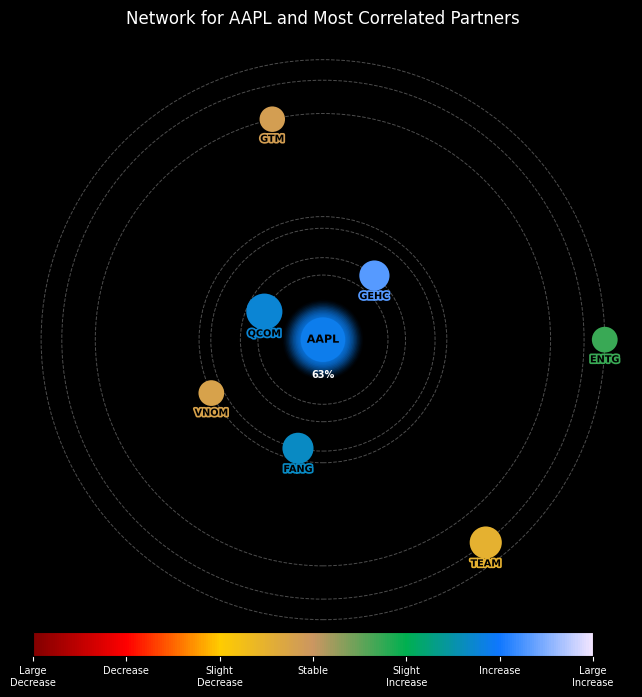

In [46]:
# --- MODIFIED: Run App ---
min_nodes, max_nodes, threshold_percent = 4, 50, 0.9
ticker = 'AAPL'

processed_data = process_stock_correlations(unified_factor_df, min_market_cap_df, min_nodes, max_nodes, threshold_percent)
prediction_score = calculate_prediction_score(ticker, processed_data, min_market_cap_df, last_day_changes, std_devs)

print(f"\nPrediction Score for {ticker}: {prediction_score:.2f}")
if prediction_score > 0.9:
    print("Outlook: Strong Increase Signal")
elif prediction_score > 0.5:
    print("Outlook: Increase Signal")
elif prediction_score < -0.9:
    print("Outlook: Strong Decrease Signal")
elif prediction_score < -0.5:
    print("Outlook: Decrease Signal")
else:
    print("Outlook: Neutral/Mixed Signals")

plot_ticker_network_visual(processed_data, ticker, std_devs, last_day_changes, min_market_cap_df, prediction_score)


In [36]:
# prompt: Generate a list of the top prediction scores. This should be a list of the ticker and the prediction score. The prediction score should be larger than 95% and sort them by greatest to least

import pandas as pd
# Calculate prediction scores for all tickers in the processed data
all_tickers = processed_data['source'].unique().tolist()
prediction_scores = []

for ticker in tqdm(all_tickers, desc="Calculating Prediction Scores"):
    score = calculate_prediction_score(ticker, processed_data, min_market_cap_df, last_day_changes, std_devs)
    prediction_scores.append({'ticker': ticker, 'score': score})

# Create a DataFrame from the scores
prediction_df = pd.DataFrame(prediction_scores)

# Filter for scores greater than 0.95 (95%)
high_prediction_df = prediction_df[prediction_df['score'] > 0.95].copy()

# Sort the filtered DataFrame by score in descending order
sorted_high_predictions = high_prediction_df.sort_values(by='score', ascending=False)

# Convert the sorted DataFrame to a list of dictionaries
top_predictions_list = sorted_high_predictions.to_dict('records')

# Print the list of top predictions
print("\nTop Prediction Scores (> 95%), sorted high to low:")
for item in top_predictions_list:
    print(f"  {item['ticker']}: {item['score']:.2%}")

Calculating Prediction Scores:   0%|          | 0/261 [00:00<?, ?it/s]


Top Prediction Scores (> 95%), sorted high to low:
  AKAM: 100.00%
  AUR: 100.00%
  BMRN: 100.00%
  CHRW: 100.00%
  CMCSA: 100.00%
  CSGP: 100.00%
  EVRG: 100.00%
  HOLX: 100.00%
  FANG: 100.00%
  GTM: 100.00%
  GEHC: 100.00%
  INSM: 100.00%
  MDLZ: 100.00%
  KSPI: 100.00%
  JBHT: 100.00%
  TMUS: 100.00%
  VNOM: 100.00%
  ROST: 100.00%
  MNST: 100.00%
  PAA: 100.00%
  REGN: 100.00%
  PFG: 100.00%
  PCAR: 100.00%
  TEAM: 99.48%
  ENTG: 99.20%
  UTHR: 99.06%
  MU: 98.86%
  FTAI: 98.69%
  ON: 96.83%
  MDB: 95.17%
  CTSH: 95.08%
